In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, binom, bernoulli, multivariate_normal
from functools import partial
entropy=partial(entropy, base=2)
np.random.seed = 42

Latex macros
$\renewcommand{\vec}[1]{\mathbf{#1}}$
$\renewcommand{\ex}[1]{\mathbb{E}\left[{#1}\right]}$
$\renewcommand{\dkl}[2]{D_\text{KL}\left(\mathbf{#1\|#2}\right)}$
$\renewcommand{\hyp}{\mathcal{H}}$
$\renewcommand{\soin}{s_\text{in}}$
$\renewcommand{\sout}{s_\text{out}}$

# Probabilities and Inference

As the title suggests, we deal with inference problems in this part, Mostly with bayesian methods I suppose. It's less linear and more of a hodgepodge. The problems can be categorized as follows:
- Exact methods
- Deterministic approximations
- Monte Carlo methods

One misconception to note is the the aim of inference is not to find _the most probable explanation_ for some data, but the whole distribution. The most probable hypothesis given some data may be atypical of the whole set of reasonably-plausible hypotheses.

## An Example Inference Task: Clustering
We will go over this quickly as I'm already familiar with Clustering.  
Why cluster?
1. A good clustering has predictive power-we believe the underlying cluster labels are meaningful.
2. Clusters can be a useful aid to communication as a form of lossy compression.
3. Failures of the cluster model may highlight interesting objects that deserve special attention.
4. Clusters can serve as models of learning processes in neural systems.

So we have $N$ data points, $K$ labels, and we want to assign $\vec x\to k(\vec x)$ in a way that minimizes the expected _distortion_
$$D=\sum_{\vec x}P(\vec x)\frac12\left[\vec m^{(k(\vec x))}-\vec x\right]^2$$
where $\vec m^{k(\vec x)}$ is a representative for the $k(\vec x)$'th cluster.

Let's see a toy example:

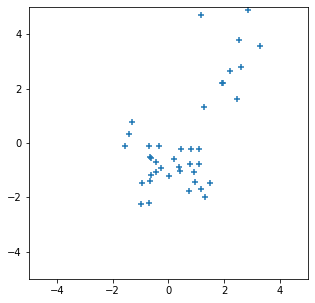

In [101]:
# first we generate some data points and plot them
m1, v1 = [0.,-1.], [[.75,0]
                  ,[0.,.5]]
m2, v2 = [2.,3.], [[0.5,0]
                  ,[0.,1.]]
X = np.vstack([multivariate_normal.rvs(m1,v1,size=30)
             ,multivariate_normal.rvs(m2,v2,size=10)])
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:,0],X[:,1],marker="+")
ax.set(xlim=[-5.0,5.0], ylim=[-5,5]);

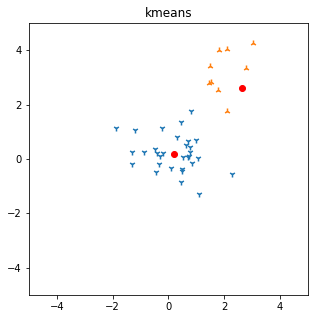

In [64]:
def plot_means(X, M, k_X, title="kmeans"):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.set(xlim=[-5.0,5.0], ylim=[-5,5],title=title);
    ax.scatter(M[:,0],M[:,1],marker="o",c='red')
    markers = ["1","2","3","4"]+["."]*(len(k_X)-4)
    for i in range(len(k_X)):
        members = k_X==i
        ax.scatter(X[members,0],X[members,1],marker=markers[i])
        

# X - data points
# k - number of clusters
# d - distance function
def kmeans(X, d, k=2):
    # we need to initialize k representatives somehow
    def assign():
        k_X = np.array([-1]*X.shape[0])
        for i, x in enumerate(X):
            k_X[i] = min(range(k),key=lambda j:d(x, M[j]))
        return k_X
    M = X[np.random.choice(X.shape[0], size=k, replace=False)]
    k_X = assign()
    while True:
#         plot_means(X, M, k_X, title="assign")
        for i in range(M.shape[0]):
            members = X[k_X==i]
            if members.any():
                M[i] = np.mean(X[k_X==i])
#         plot_means(X, M, k_X, title="sample mean")
        new_k_X = assign()
        if (new_k_X == k_X).all():
            break
        k_X = new_k_X
    return M, k_X
        
k = 2
M, k_X = kmeans(X, lambda x,y:np.linalg.norm(x-y), k=k)
plot_means(X, M, k_X)

**Exercise 20.1** Prove K-means always converges.
We claim after each step the sum of distances $\sum_id(x_i,k(x_i))$ from cluster representatives decreases. Let $\{x_i\}$ be our $N$ data points and $\{m_j^s\}$ our $K$ means on step $s$. After the assign stage, $d(x_i,k^{s+1}(x_i))\leq d(x_i,k^{s}(x_i))$ with strict inequality if there was a change, therefore the sum over all data-points decreases. A property of the sample mean of a set is that it minimizes the sum of distances, therefore after the update step $$\sum_id(x_i,k^{s+1}(x_i))=\sum_j\sum_{x,k^{s+1}(x)=m_j}d(x_i,m_j^{s+1})\leq\sum_j\sum_{x,k^{s+1}(x)=m_j}d(x_i,m_j^s)$$

Okay apart from some abuse of notation the idea is clear: if there's a change in assignment the sum strictly decreases. How do we know it doesn't keep decreasing forever? Let's assume by contradiction it does. There is a finite number of possible assignments $\{1,\dots,k\}\to\{1,\dots,N\}$, $\frac{N!}{k!}$, so if we iterate forever we must have at some point repeated an assignment, but the sum of distances after the update step depends only on the assignment, so we contradict the proof that after each iteration the sum strictly decreases.

Some doubts with k-means:
- adhoc features: mean as rep, choice of distance, choice of K, result depends on initial choice of means.
- the algorithm has no way of representing the size or shape of a cluster
- 'hard' algorithm, treats borderline cases as equals.

Let's see a variant called soft-K-means:

#-steps=273


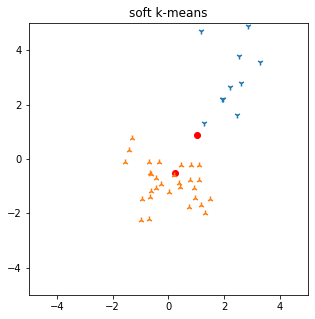

In [129]:
def soft_kmeans(X, d, beta=1, k=2):
    # we need to initialize k representatives somehow
    def assign():
        r = np.zeros((k,X.shape[0]))
        for i in range(k):
            for j, x in enumerate(X):
                r[i,j] = -beta*d(x, M[i])
        r = np.exp(r)
        r /= np.sum(r,axis=0)
        return r
    M = X[np.random.choice(X.shape[0], size=k, replace=False)]
    r = assign()
    for s in range(1000):
#         plot_means(X, M, k_X, title="assign")
        M = (r@X)/np.sum(r,axis=1)[:,None]
#         plot_means(X, M, k_X, title="sample mean")
        new_r = assign()
        if (new_r == r).all():
            break
        r = new_r
    print(f"#-steps={s}")
    return M, r

k = 2
d = lambda x,y:np.linalg.norm(x-y)
M, r = soft_kmeans(X, d, beta=0.7, k=k)
k_X = np.array([-1]*X.shape[0])
for i, x in enumerate(X):
    k_X[i] = min(range(k),key=lambda j:d(x, M[j]))
plot_means(X, M, k_X,title="soft k-means")

Now it can iterate forever, whats the halting rule? Maybe not, I suppose eventually this change in r is too small for the floating point precision?

In the book he states that $\beta$ is an inverse-length-squared (i'm not sure how to justify this), so $\sigma=1/\sqrt{\beta}$, although I use the norm as a distance so maybe not square root. Anyway $\beta$ is kind of like an expected size of the cluster, but we still can't handle different weight (some clusters may be under-represented in the data) or shape, and now we have another parameter.

### Exercises
The exercises deal with properties of soft k-means. Skipping for now.

## Exact Inference by Complete Enumeration

We will now see a nice use of bayesian probability in a "real-life" situation, and examine why enumerating and comparing all the possible hypotheses is not feasable.

Fred lives in Los Angeles and commutes 60 miles to work. Whilst at work, his neighbour calls saying that Fred's burglar alarm is ringing. What is the probability there was a burglar in his house today? while driving home, he hears on the radio there was a small earthquake near his home. What is the probability there was a burglar in his house?

We introduce the following variables:
- $b$: burglar was present
- $a$: the alarm is ringing
- $p$: fred recieves a phonecall
- $e$: a small earthquare takes place near house
- $r$: the radio report of earthquake is heard by fred

Then
$$P(b,e,a,p,r)=P(b)P(e)O(a\mid b,e)P(p\mid a)P(r\mid e)$$
How did we reach this factorization? $P(a\mid b,e)P(b)P(e)=P(b,e,a)$ ($b$ and $e$ can be considered independent, and the rest is from def). For the rest I'm not sure... Carrying on

Plausible values:
1. Burglar probability $P(b=1)=\beta$, e.g. $\beta=0.001$.
2. Earthquake probability $P(e=1)=\varepsilon$, $\varepsilon=0.001$
3. Alam ringing probability
$$\begin{align}
P(a=0\mid b=0,e=0)&=(1-f),                         & P(a=1\mid b=0,e=0)&=f\\
P(a=0\mid b=1,e=0)&=(1-f)(1-\alpha_b),             & P(a=1\mid b=1,e=0)&=1-(1-f)(1-\alpha_b)\\
P(a=0\mid b=0,e=1)&=(1-f)(1-\alpha_e),             & P(a=1\mid b=0,e=1)&=1-(1-f)(1-\alpha_e)\\
P(a=0\mid b=1,e=1)&=(1-f)(1-\alpha_e)(1-\alpha_b), & P(a=1\mid b=1,e=1)&=1-(1-f)(1-\alpha_e)(1-\alpha_b)\\
\end{align}$$
with $f=0.001$ false alarm, $\alpha_b=0.99$ reliability of burglar alarm when burglar enters house and $\alpha_e=0.01$ probability of an earthquake trigerring an alarm.
4. we also assume $P(p=1\mid a=0)=0$ and $P(r=1\mid e=0)=0$.

We now have enough to calculate the posterior probability of $b$ and $e$,
$$P(b,e\mid a=1)=\frac{P(a=1\mid b,e)P(b)P(e)}{P(a=1)}$$

In [236]:
beta = 1e-3      # prior prob of burglar
epsilon = 1e-3   # prior prob of earthquake
f = 1e-3         # probability of unrelated alarm failure
a_beta = 0.99    # accuracy of alarm when burglar intrudes
a_eps = 1e-2     # prob of earthquake triggering alarm
a_eq_0 = np.array([[1-f,(1-f)*(1-a_eps)] # cond prob, b rows and e columns
                  ,[(1-f)*(1-a_beta), (1-f)*(1-a_beta)*(1-a_eps)]])
a = np.stack([a_eq_0, 1- a_eq_0])
b = np.array([1-beta,beta])
e = np.array([1-epsilon,epsilon])
p_a1 = b@a[1]@e
p_be_a1 = b[:,None]*a[1]*e/p_a1
p_b_a1 = np.sum(p_be_a1,axis=1)
p_b_e1a1 = p_be_a1[:,1]/np.sum(p_be_a1[:,1])
print(f"p(b|a=1)    ={p_b_a1}")
print(f"p(b|e=1,a=1)={p_b_e1a1}")

p(b|a=1)    =[0.50474487 0.49525513]
p(b|e=1,a=1)=[0.91727797 0.08272203]


Theres definitely a better way to handle all the conditional probabilities. Graphical models?

So just learning about the alaram gives us a 50% chance of having a burglar, but hearing about the earthquake reduces it down to 8%. Also, in the posterior, $b$ and $e$ are not independent!

The phenomenon where one possible cause of some data becomes less probable when another of the causes becomes more probable, even though those two causes were independent variables _a priori_, is known as explaining away.

To solve this inference questions we enumerated all four hypotheses $(b,e)$ and calculated the posterior probabilites, marginalizing to obtain the required information about $b$.

**Exercise 21.2** After fred receives the phone-call about the burglar alarm, but before he hars the radio report, what, from his point of view, is the probability that there was a small earthquake today?  
We want to know $P(e=1\mid a=1)$. We'll marginalize $P(b,e\mid a=1)$ over $b$.

In [258]:
f"P(e|a=1)={np.sum(p_be_a1,axis=0)}"

'P(e|a=1)=[0.99401242 0.00598758]'

So the odds are now six times bigger, but still pretty small.

### Exact inference for continuous hypothesis spaces

Example: Inferring mean and std of gaussian from observed data. Here are plots of pdfs of 10X10 hypotheses for these parameters.

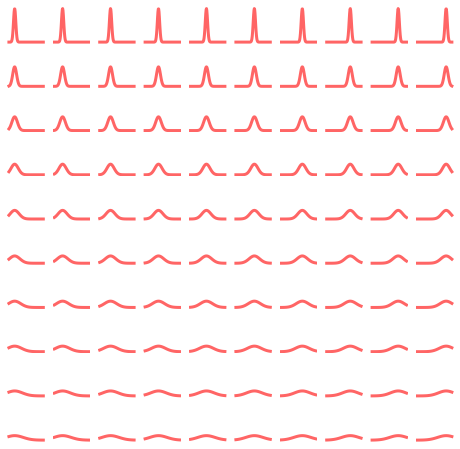

In [321]:
from itertools import product
n_mu = 10
n_sigma = 10
fig, ax = plt.subplots(n_mu, n_sigma,figsize=(8,8),sharex=True, sharey=True)
x = np.linspace(-2,
                4, 100)
mu = np.linspace(-1,3,num=n_mu)
sigma = np.linspace(0.2, 1.5, num=n_sigma)
for i,j in product(range(n_mu), range(n_sigma)):
    ax[i,j].plot(x, norm.pdf(x,loc=mu[j],scale=sigma[i]),
           'r-', lw=3, alpha=0.6, label='norm pdf')
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].spines['left'].set_visible(False)
    ax[i,j].axis('off')

Now let's sample some data and see which hypothesis is more likely. The data is generated from a gaussian plus an outlier.

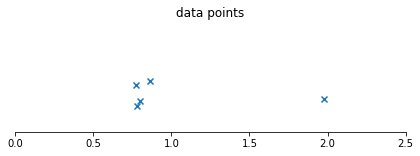

In [305]:
samples = np.hstack([norm.rvs(loc=0.7,scale=0.2, size=4), 1.98])
fig,ax = plt.subplots(figsize=(7,2))
ax.scatter(samples, norm.rvs(loc=0.8,scale=0.1,size=5), marker='x')
ax.set(title="data points", xlim=[0,2.5], ylim=[0.5,1.5])
ax.set_yticks([],[])
for s in ('left','top','right'):
    ax.spines[s].set_visible(False)

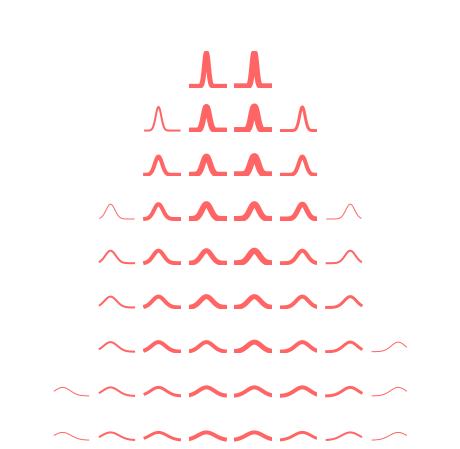

In [322]:
fig, ax = plt.subplots(n_mu, n_sigma,figsize=(8,8),sharex=True, sharey=True)

for i,j in product(range(n_mu), range(n_sigma)):
    likelyhood = np.prod(norm.pdf(samples,loc=mu[j],scale=sigma[i]))
    lw = 0 if likelyhood < np.exp(-10) else int(np.log(likelyhood)+11)
    if lw > 0:
        ax[i,j].plot(x, norm.pdf(x,loc=mu[j],scale=sigma[i]),
               'r-', lw=lw, alpha=0.6, label='norm pdf')
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].spines['left'].set_visible(False)
    ax[i,j].axis('off')

The line width marks which hypothesis is more likely, with hypotheses with likelyhood less than $e^{-10}$ removed.

The likelyhood function is
$$P(x\mid \mu,\sigma)=\frac1{\sqrt{2\pi}\sigma}\exp{\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)}$$
As a function of $\mu,\sigma$.

As we said, the data is with an outlier, so it is perhaps more likely it came from a gaussian mixture model ($0\leq\beta\leq1$)
$$P(x\mid \mu_1,\sigma_1,\beta,\mu_2,\sigma_2)=\frac\beta{\sqrt{2\pi}\sigma_1}\exp{\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)}+\frac{1-\beta}{\sqrt{2\pi}\sigma_2}\exp{\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right)}$$

Again we can enumerate all subhypotheses, but now we have a five dimensional space, so even when discretized the amount of hypotheses grows exponentially. 

We can compare the two models by evaluating the marginal likelihood or evidence for each model $\hyp$. We need to integrate over the parameters $\theta$, or instead summing over the subhypotheses sampled (we take the distribution over $\theta$ to be uniform).
$$P(\{x\}\mid\hyp)=\sum_\theta P(\theta)P(\{x\}\mid\theta,\hyp)$$
The author claims that if the uncertainty about each of $K$ parameters has been reduced by a factor of ten by observing the data, then brute-force integration requires a grid of at least $10^K$ points (i think because the integral becomes finer).

## Maximum Likelihood and Clustering
TBD

## Useful Probability Distributions
TBD

## Exact Marginalization
TBD
+Trelisses, Graphs

## Laplace's Method
TBD

## Model Comparison and Occam's Razor
TBD

## Monte Carlo Methods

We want to solve two problems  
**Problem 1:** to generate samples $\{\vec x^{(r)}\}_{r=1}^R$ from a given probability distribution $P(\vec x)$.  
**Problem 2:** to estimate expectations of functions under this distribution, for example
$$\left<\phi(\vec x)\right>=\int d^N\vec xP(\vec x)\phi(\vec x)$$

Why? if $P(\vec x)$ is the posterior of our inference problem, perhaps we want to sample some possible parameters and see how they vary. The second problem can be used, beyond mere estimation of moments, to answer questions such as how likely it is that such and such happens and use $\phi$ as some $\mathbb{1}$ function.

Keep in mind that the only sampling method I know of is the one akin to stream code, and that requires a discrete (and finite?) distribution.

If we solve the first problem, we could solve the second using the sample mean estimator
$$\hat\phi=\frac1R\sum_r\phi(\vec x^{(r)}$$
An interesting observation is that the variance of $\hat\phi$ doesn't depend on the dimensionality of $\vec x$ but the variance of $\phi$.

### Why is sampling from $P(\vec x)$ hard?
We assume we can evaluate $P^*(\vec x)$ s.t
$$P(\vec x)=P^*(\vec x)/Z$$
Why can we not easily solve probelm 1?